In [25]:
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
import hyperopt
import os
import seaborn as sn
from hpsklearn import HyperoptEstimator,random_forest,HyperoptEstimator,any_classifier,any_preprocessing
import hyperopt as hp
from hpsklearn import svc
from sklearn.model_selection import train_test_split
from hyperopt import tpe
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.svm import SVC


## Data Prep

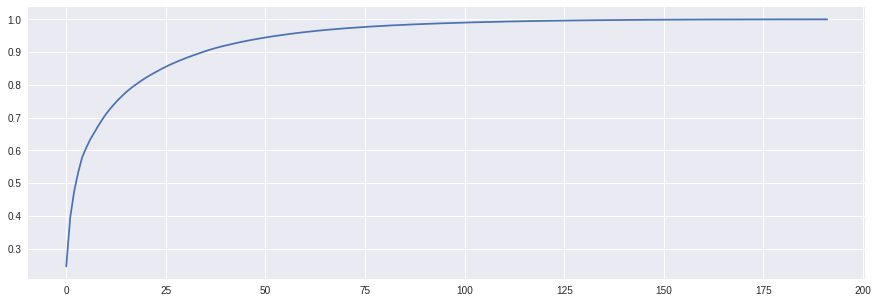

In [27]:
path = "/media/kashraf/Elements/Dissertation/data/preprocessed/visual/psd_data_noisy/"
data1 = pd.read_csv(os.path.join(path,"beta_13_psd.csv"),index_col=0).iloc[:,:64]
data2 = pd.read_csv(os.path.join(path,"theta_13_psd.csv"),index_col=0).iloc[:,:64]
data3 = pd.read_csv(os.path.join(path,"alpha_13_psd.csv"),index_col=0)

data= pd.concat([data1,data2,data3],axis=1)

x=data.iloc[:,:-1]
y=data.iloc[:,-1]

scaler=StandardScaler()
x=scaler.fit_transform(x)

pca1=PCA()

pca_data=pca1.fit_transform(x)
components=pca1.components_
explained_var=pca1.explained_variance_ratio_
plt.style.use("seaborn")
plt.figure(figsize=(15,5))
plt.plot(range(len(components)),np.cumsum(explained_var))



## Sample selection

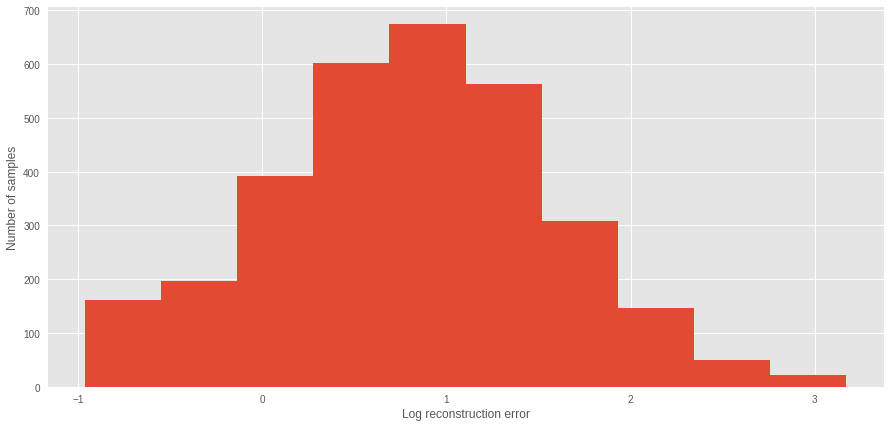

In [28]:
def eigen_sample_select(data,n_comps):
    pca=PCA(n_components=n_comps)
    
    # Fit and project
    projected=pca.fit_transform(data)
    eigen_space=pca.components_
    
    # Renconstuction
    recons=np.dot(projected,eigen_space)
    recon_error=data-recons
    recon_error=np.linalg.norm(recon_error,axis=1)
    
    return recon_error
err=eigen_sample_select(x,40)
    
#__________________histogram plot___________________________________
plt.style.use("ggplot")
plt.figure(figsize=(15,7))
plt.hist(np.log(err))
plt.xlabel("Log reconstruction error"),plt.ylabel("Number of samples")
# plt.show()
# plt.savefig("Errorhist.jpg")

#____________________________Sample index selection____________________
def ci_data_selection(errors):
    error=np.log(errors)
    sorted_data=np.sort(error)
    l_limit= np.percentile(sorted_data,25)
    u_limit=np.percentile(sorted_data,75)
    id_selected=[]
    for index , err in enumerate(error):
        if l_limit<=err and err<=u_limit:
            id_selected.append(index)
    return id_selected
selected_index=ci_data_selection(err)

### New data set from new samples

In [39]:
new_data=pd.DataFrame(data.values[selected_index])
x=new_data.iloc[:,:-1]
y=new_data.iloc[:,-1]
scaler=StandardScaler()
x=scaler.fit_transform(x)

#__________________ Train test split__
x=PCA(n_components=32).fit_transform(x)
x_train,x_test,y_train, y_test= train_test_split(x,y,test_size=0.3)
print("X_train:",x_train.shape)
print("x_test:",x_test.shape)
print("y_train:",y_train.shape)
print("y_test:",y_test.shape)


X_train: (1090, 32)
x_test: (468, 32)
y_train: (1090,)
y_test: (468,)


## Modelling

In [41]:
# ______________________Hyper parameter optimization_________________________
estim=HyperoptEstimator(classifier=any_classifier("clf"),algo=tpe.suggest,max_evals=100,
                          trial_timeout=100,n_jobs=12)
estim.fit(x_train,y_train)
print(estim.best_model())

 88%|████████▊ | 7/8 [01:21<?, ?trial/s, best loss=?]
{'learner': SVC(C=30.38798567530876, cache_size=512, degree=1, gamma='auto',
    kernel='linear', max_iter=153661243.0, random_state=1, shrinking=False,
    tol=0.0005723056105086699), 'preprocs': (StandardScaler(with_mean=False, with_std=False),), 'ex_preprocs': ()}


## Model evaluation

In [40]:
model=AdaBoostClassifier(learning_rate=0.014581838611158991, n_estimators=11,
                   random_state=1)
# x_train=StandardScaler().fit_transform(x_train)
model.fit(x_train,y_train)
# x_test=StandardScaler().fit_transform(x_test)
y_pred=model.predict(x_train)
print("Report: ", classification_report(y_train,y_pred))

Report:                precision    recall  f1-score   support

         1.0       0.27      0.96      0.42       280
         2.0       0.55      0.09      0.15       266
         3.0       0.00      0.00      0.00       275
         4.0       0.47      0.07      0.12       269

    accuracy                           0.28      1090
   macro avg       0.32      0.28      0.17      1090
weighted avg       0.32      0.28      0.17      1090



/home/kashraf/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
fro